In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import load_dataset
import numpy as np

import utils
import visualize
import metric
import dae
import trainer

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Download DDPM_checkpoint.pth or Train DDPM

### Setting

In [2]:
seed = 42

utils.set_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [38]:
### DDPM model setting

batch_size = 128
learning_rate = 1e-3
num_epochs = 5
image_size = 28 # 28 * 28
timesteps = 1000
dim = 64 # Unet latent dimension
channels = 1 # image channel

load_diffusion = True # True if load DDPM weight
diffusion_path = './ckpts/DDPM_checkpoint.pth'

In [39]:
### load fashion_mnist dataset
dataset = load_dataset("fashion_mnist")

# define function
transformed_dataset = dataset.with_transform(utils.transform_fuc)#.remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

### Model

In [40]:
# DDPM Model

model = Unet(
    dim = dim,
    dim_mults = (1, 2, 4),
    channels = channels,
    flash_attn = False
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = image_size,
    timesteps = timesteps,    # number of steps
    objective = 'pred_noise',
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [41]:
# load Diffusion model weight (load_diffusion = True)

if load_diffusion:
    checkpoint = torch.load(diffusion_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    diffusion.load_state_dict(checkpoint['diffusion_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Diffusion model Train (load_diffusion = False)

else:
    for epoch in tqdm(range(num_epochs)):
        for step, inputs in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()

            training_images = inputs['pixel_values'].to(device)
            loss = diffusion(training_images)

            if step % 100 == 0:
                print("Loss:", loss.item())
            loss.backward()
            optimizer.step()

    # Save Diffusion model state
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'diffusion_state_dict': diffusion.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    torch.save(checkpoint, diffusion_path)

## 2. Choose one User Choice Item from Real FashionMNIST

2
5
7
9
1


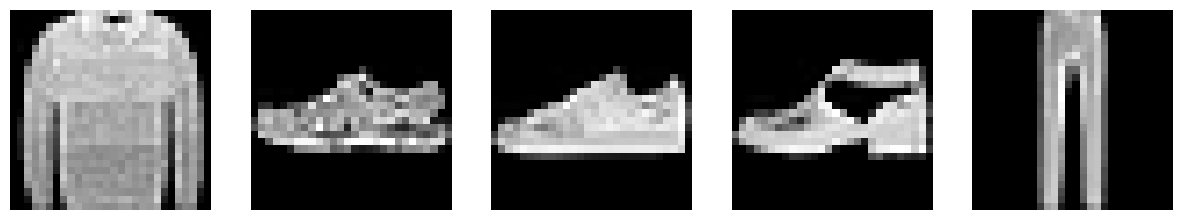

In [7]:
# Choose Images as many as the number of samples

start_idx = 20 
num_samples = 5 # Number of images to visualize

chosen_r_datasets = transformed_dataset['test'][start_idx: start_idx + num_samples]['pixel_values']
chosen_r_labels = transformed_dataset['test'][start_idx: start_idx + num_samples]['label']

visualize.sample_figures(num_samples, chosen_r_datasets, labels=chosen_r_labels)

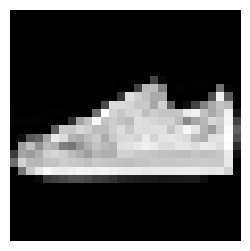

In [8]:
# Select one from the images above (0 ~ num_samples - 1)
chosen_idx = 2
chosen_r_dataset = chosen_r_datasets[chosen_idx]

visualize.sample_figure(dataset = chosen_r_dataset)

## 3. Generate Fake Image From Noise Z with DDPM

In [29]:
sample_batch_size = 50 # Number of images to generate

# Generate Image
# Repeat until an image similar to the chosen_r_dataset appears.

sampled_images = diffusion.sample(batch_size = sample_batch_size) 
sampled_images.shape # (sample_batch_size, channels, image_size, image_size)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([50, 1, 28, 28])

## 4. Choose Generated Image similar with chosen from Real data, and regenerate

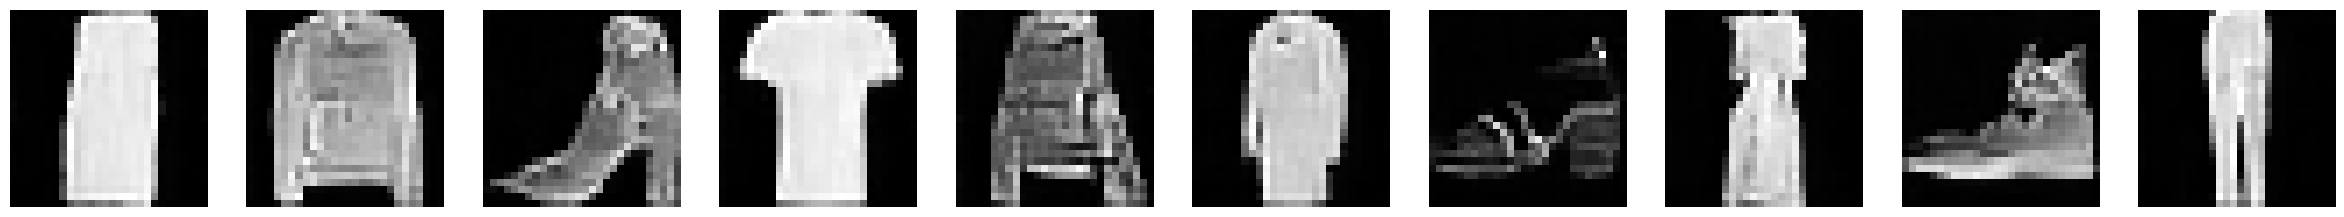

In [30]:
# Generate images as many as sample_batch_size 


start_idx = 30 # 0 ~ (sample_batch_size - num_samples)
num_samples = 10 # Number of images to visualize

chosen_gen_datasets = sampled_images[start_idx:start_idx + num_samples , :, :, :]

# visualize generated items
visualize.sample_figures(num_samples = num_samples, datasets = chosen_gen_datasets)


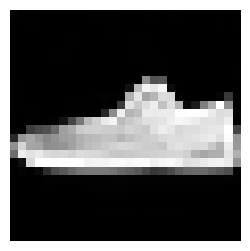

In [38]:
# Choose generated image one from the images above [0, num_samples - 1]
chosen_idx = 1

chosen_gen_dataset = chosen_gen_datasets[chosen_idx] # Select one from the images above (0 ~ num_samples - 1)
normalized_gen_img = chosen_gen_dataset.cpu().apply_(lambda x: (x * 2) - 1) # normalize from [0, 1] to [-1, 1] 

# visualize genearated image similar with user choice
visualize.sample_figure(dataset = normalized_gen_img)

In [39]:
# cosine_sim
gen_cosine_sim, gen_euc = metric.calculate_similarity(normalized_gen_img, chosen_r_dataset)

print(f'cosine_sim: {gen_cosine_sim}') # first generated data cosine similarity
print(f'euclidean_distance: {gen_euc}') # first generated data euclidian distance

cosine_sim: 0.24586834013462067
euclidean_distance: 25.27942657470703


## 5. Regenerate until regenerate image from noise similar to chosen image (DDPM iteration)

In [ ]:
t_num = 200
x_start = normalized_gen_img
sample_batch_size = 10 # Number of images to generate

start_index = 0
num_samples = 10

end_index = start_index + num_samples

iterate_num = 10 # diffusion iterate num

max_cosine_sim = gen_cosine_sim

x_list = [x_start]
for i in range(iterate_num):
    cosine_sim = 0 # Initialized to 0 to enter while loop
    
    # Repeat 1 iteration until cosine similarity increases
    while max_cosine_sim > cosine_sim:
        # regenerate image with DDPM
        x_start, x_p, _ = utils.regenerate_image(diffusion, x_start, device, t_num = t_num, batch_size = sample_batch_size) 

        # Select the image with the highest similarity to the user-selected item among DDPM regenerate images.
        x = utils.compare_chosen_generated(start_index, end_index, chosen_r_dataset, x_p, device)

        cosine_sim, euc = metric.calculate_similarity(x, chosen_r_dataset)

        print(f'cosine_sim: {cosine_sim}')
        print(f'euclidean_distance: {euc}')

        # if cosine_similarity increases than previous iteration
        if max_cosine_sim <= cosine_sim:
            print(f'iterate {i + 1}')
            max_cosine_sim = cosine_sim
            x_start = x
            x_list.append(x_start)

## 6. Denoise Regenerated Image with DAE (with CNN layer)

#### DAE Setting

In [31]:
batch_size = 128 
learning_rate = 1e-3
num_epochs = 5

In [32]:
# dataset

mnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
c = 64 # first cnn layer channel
latent_dim = 64 # DAE Encoder output dimension
noise_ratio = 0.1 # DAE added noise ratio

dae_model = dae.DAE_CNN(c, latent_dim).to(device)
dae_optimizer = torch.optim.Adam(dae_model.parameters(), lr=learning_rate)

criterion = nn.BCELoss()

load_DAE = True # True if load DAE weight
dae_path = './ckpts/DAE_CNN_checkpoint.pth'

In [35]:
# load DAE model weight (load_DAE = True)

if load_DAE:
    checkpoint = torch.load(dae_path)
    dae_model.load_state_dict(checkpoint['model_state_dict'])
    dae_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# DAE model Train (load_DAE = False)

else:
    # Train DAE
    best_model_high, train_loss_history_high, val_loss_history_high = trainer.train_model(dae_model, dataloaders, criterion, dae_optimizer, device, num_epochs=num_epochs, noise_ratio=noise_ratio)
    
    checkpoint = {
    'model_state_dict': best_model_high.state_dict(),
    'optimizer_state_dict': dae_optimizer.state_dict(),
    }

    torch.save(checkpoint, dae_path)

In [46]:
# Calculate DAE latent vector level similarity between user select image and DDPM output
similarity_list, euc_list = metric.calculate_DAE_similarity(dae_model, chosen_r_dataset, x_list, device)

### Visualize

maximum similarity DDPM iteration: 10


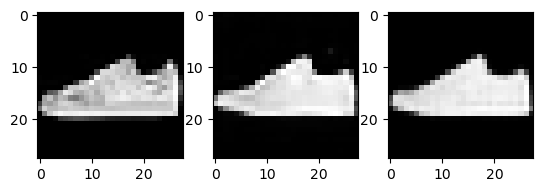

In [47]:
# Visualization of results with highest DAE latent vector level similarity between user select image and DDPM output
denoised_img = visualize.maximum_similarity_result_figure(dae_model, similarity_list, x_list, chosen_r_dataset, device)

Text(0, 0.5, 'Cosine Similarity')

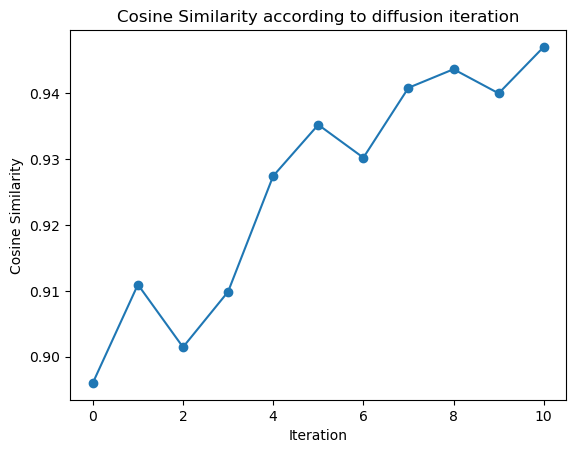

In [48]:
# Visualize DAE latent vector level Cosine similarity between user select image and DDPM output

plt.plot(similarity_list, marker='o')
plt.title('Cosine Similarity according to diffusion iteration')
plt.xlabel('Iteration')
plt.ylabel('Cosine Similarity')

Text(0, 0.5, 'Euclidean Distance')

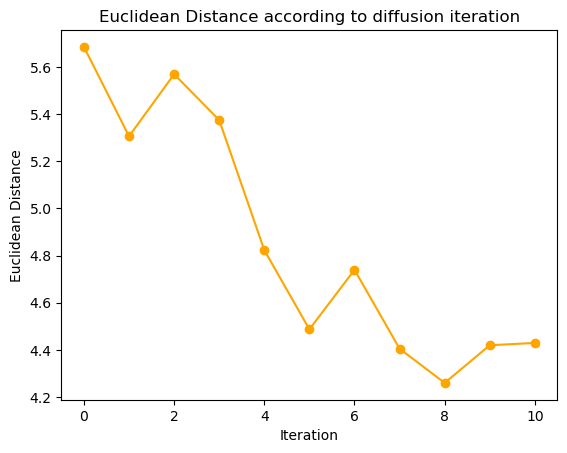

In [49]:
# Visualize DAE latent vector level Euclidean Distance between user select image and DDPM output

plt.plot(euc_list, marker='o', color='orange')
plt.title('Euclidean Distance according to diffusion iteration')
plt.xlabel('Iteration')
plt.ylabel('Euclidean Distance')

## 7. Find the real top 10 items closest to the generated item

In [50]:
# Dataloader for Find near top10 item

dataloaders['train'] = DataLoader(mnist_train, batch_size=1, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=1, shuffle=False)

In [51]:
# Similarity is calculated only for items with the same label as the user-selected item

label_num = 7

real_image_list, real_similarity_list, real_euc_list = metric.calculate_real_similarity(dataloaders, dae_model, denoised_img, noise_ratio, device, label_num)

100%|██████████| 60000/60000 [00:12<00:00, 4903.50it/s]


In [52]:
# Select the top 10 real image indices with the highest cosine similarity to the generated image.

top_10_indexes = utils.top_n_indexes(real_similarity_list, 10)

result_top10_list = real_image_list[top_10_indexes] # real top10 image

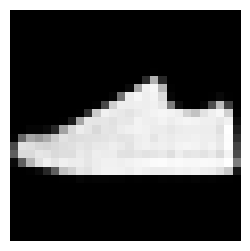

In [53]:
# Visualize Genearated Image
visualize.sample_figure(denoised_img)

Top 1 Cosine similarity : 0.9577232599258423
Top 2 Cosine similarity : 0.9547901153564453
Top 3 Cosine similarity : 0.9516906142234802
Top 4 Cosine similarity : 0.9514266848564148
Top 5 Cosine similarity : 0.9508310556411743
Top 6 Cosine similarity : 0.9498608112335205
Top 7 Cosine similarity : 0.9493772387504578
Top 8 Cosine similarity : 0.949231743812561
Top 9 Cosine similarity : 0.948133647441864
Top 10 Cosine similarity : 0.9476333260536194


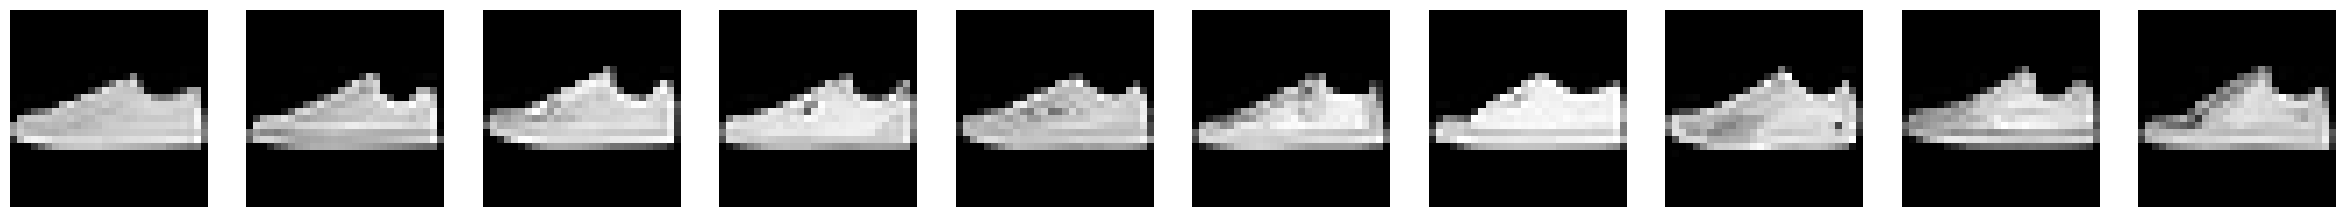

In [54]:
# Visualization of the 10 real items with the highest similarity to the Generated Image at the DAE latent vector level

# Top 10 Cosine Similarity Indexing
cos_top10_list = np.array(real_similarity_list)[top_10_indexes]

# Print Top 10 Cosine similarity
for i, cosine in enumerate(cos_top10_list):
    print(f'Top {i + 1} Cosine similarity : {cosine}')

visualize.sample_figures(10, result_top10_list)